In [28]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import joblib
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [29]:
symbol = 'META'
start_date = '2018-01-01'
end_date = date.today().strftime("%Y-%m-%d")

df = yf.download(symbol, start=start_date, end=end_date)
data = df['Close'].values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [30]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2018-01-02,180.161530,180.320423,176.318380,176.447468,18151900
2018-01-03,183.388947,183.498184,180.072120,180.618307,16886600
2018-01-04,183.051331,184.918294,182.822930,183.617369,13880900
2018-01-05,185.553864,185.603505,183.647169,184.302594,13574500
2018-01-08,186.973923,187.589617,185.037453,185.901413,17994700


In [31]:
df['Close']

Ticker,META
Date,
2018-01-02,180.161530
2018-01-03,183.388947
2018-01-04,183.051331
2018-01-05,185.553864
2018-01-08,186.973923
...,...
2026-02-09,677.219971
2026-02-10,670.719971
2026-02-11,668.690002


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2041 entries, 2018-01-02 to 2026-02-13
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, META)   2041 non-null   float64
 1   (High, META)    2041 non-null   float64
 2   (Low, META)     2041 non-null   float64
 3   (Open, META)    2041 non-null   float64
 4   (Volume, META)  2041 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 95.7 KB


In [33]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"=== Device used : {device} ===")

=== Device used : cpu ===


In [34]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [35]:
print(scaled_data[:5])

[[0.131141  ]
 [0.13574811]
 [0.13526616]
 [0.1388385 ]
 [0.14086562]]


In [36]:
seq_length = 60
X = []
y = []

for i in range(seq_length, len(scaled_data)):
    X.append(scaled_data[i-seq_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

In [37]:
X.shape

(1981, 60, 1)

In [38]:
y.shape

(1981, 1)

In [40]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#Convertendo para Tensores PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f'Treino: {X_train.shape}')
print(f'Teste: {X_test.shape}')

Treino: torch.Size([1584, 60, 1])
Teste: torch.Size([397, 60, 1])


In [52]:
class ModeloLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ModeloLSTM, self). __init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Pega apenas o último passo temporal
        return out

In [41]:
# Configuração de Hiperparâmetros
input_size = 1        #Temos 1 feature (close price)
hidden_size = 60      #Memória do LSTM
output_size = 1       #Prever apenas o preço
learning_rate = 0.001

In [42]:
modelo = ModeloLSTM(input_size, hidden_size, output_size)

criterio = nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)
modelo

ModeloLSTM(
  (lstm): LSTM(1, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=1, bias=True)
)

In [43]:
dataset_treino = TensorDataset(X_train, y_train)
loader = DataLoader(dataset_treino, batch_size=32,shuffle=True)
num_epochs = 50 #Vezes que o modelo vê os dados

# O DataLoader fatia os dados em lotes de 32 (batch_size)
# shuffle=True aqui é BOM: ajuda o modelo a não decorar a ordem dos dias, já que cada amostra X já contém a sequência de 60 dias internamente.


In [44]:
history = {
    'train_loss': [],
    'val_loss': []
}

modelo.train()

for epoch in range(num_epochs):
    train_losses = []
    for batch_X, batch_y in loader: # Loop interno percorrendo os pequenos lotes batch de X_train
        optimizer.zero_grad()       # Zera
        outputs = modelo(batch_X) # Preve
        loss = criterio(outputs, batch_y) # Calcula Erro
        loss.backward()             # Calcula Ajustes
        optimizer.step()           # Aplica
        train_losses.append(loss.item())
    
    # Cálculo da perda de validação (usando o conjunto de teste)
    modelo.eval()
    with torch.no_grad():
        val_outputs = modelo(X_test)
        val_loss = criterio(val_outputs, y_test)
    
    # Armazena as médias das perdas
    history['train_loss'].append(np.mean(train_losses))
    history['val_loss'].append(val_loss.item())
    
    modelo.train() # Volta para o modo de treino

    # Monitoramento (apenas para não poluir a tela, printamos a cada 10 épocas)    
    if (epoch+1) % 10 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Train Loss: {history["train_loss"][-1]:.6f}, Val Loss: {history["val_loss"][-1]:.6f}')

print("Treino com Mini-Batch concluído e perdas registradas!")

Época [10/50], Train Loss: 0.000300, Val Loss: 0.001392
Época [20/50], Train Loss: 0.000207, Val Loss: 0.000924
Época [30/50], Train Loss: 0.000189, Val Loss: 0.000826
Época [40/50], Train Loss: 0.000160, Val Loss: 0.000807
Época [50/50], Train Loss: 0.000171, Val Loss: 0.001307
Treino com Mini-Batch concluído e perdas registradas!


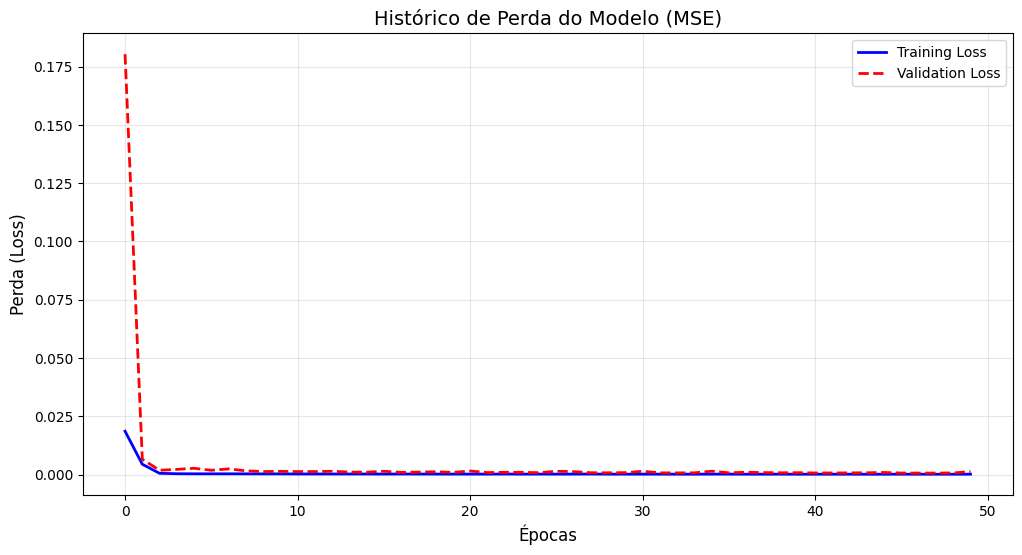

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)

plt.title('Histórico de Perda do Modelo (MSE)', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Perda (Loss)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
modelo.eval()

with torch.no_grad(): #previsões sem calcular gradientes (economiza memória)
    outputs = modelo(X_test)

outputs_np = outputs.cpu().numpy()
y_test_np = y_test.cpu().numpy()

#Inverter a Escala (Voltar de 0 e 1 para Dólares Reais)
outputs_real = scaler.inverse_transform(outputs_np)
y_test_real = scaler.inverse_transform(y_test_np)

In [47]:
mae = mean_absolute_error(y_test_real, outputs_real)
rmse = math.sqrt(mean_squared_error(y_test_real, outputs_real))

# MAPE (Mean Absolute Percentage Error) - Erro Percentual Absoluto Médio
# Fórmula: MAPE = (1/n) * Σ(|y_real - y_pred| / |y_real|) * 100
mape = np.mean(np.abs((y_test_real - outputs_real) / y_test_real)) * 100

print(f"=== Resultados da Avaliação ===")
print(f"MAE (Erro Médio Absoluto): ${mae:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): ${rmse:.2f}")
print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")
print(f"\nInterpretação:")
print(f"- O modelo erra, em média, ${mae:.2f} por ação (MAE)")
print(f"- Em termos percentuais, o erro médio é de {mape:.2f}% (MAPE)")

=== Resultados da Avaliação ===
MAE (Erro Médio Absoluto): $21.09
RMSE (Raiz do Erro Quadrático Médio): $25.32
MAPE (Erro Percentual Absoluto Médio): 3.31%

Interpretação:
- O modelo erra, em média, $21.09 por ação (MAE)
- Em termos percentuais, o erro médio é de 3.31% (MAPE)


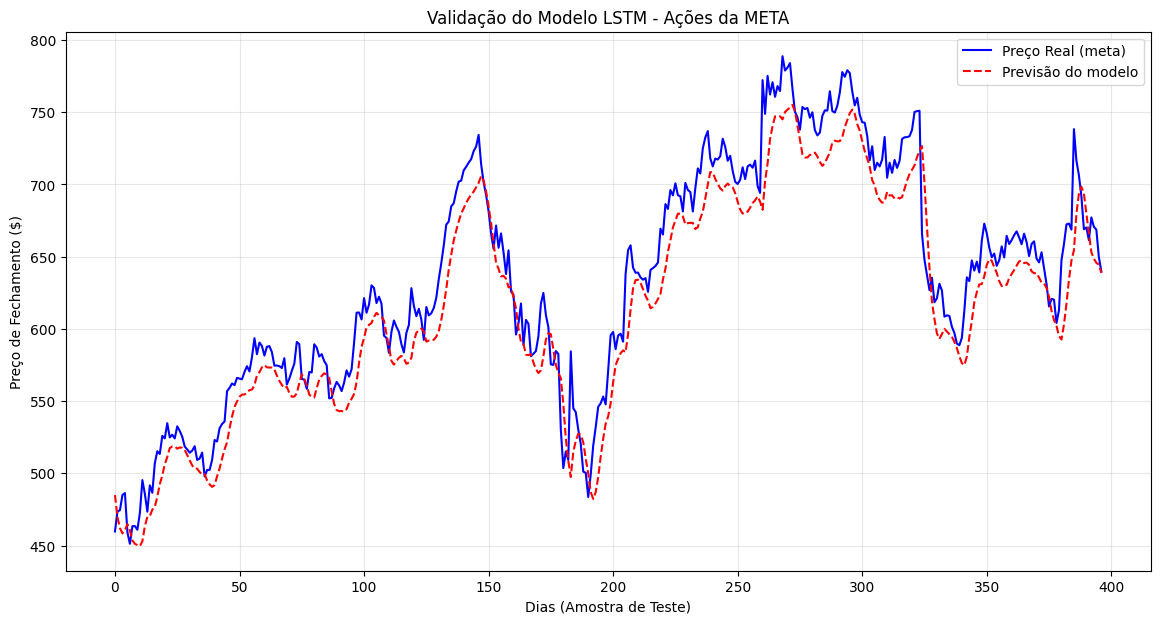

In [48]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_real, label='Preço Real (meta)', color = 'blue', linewidth=1.5)
plt.plot(outputs_real, label='Previsão do modelo', color='red', linestyle='--', linewidth=1.5)

plt.title('Validação do Modelo LSTM - Ações da META')
plt.xlabel('Dias (Amostra de Teste)')
plt.ylabel('Preço de Fechamento ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

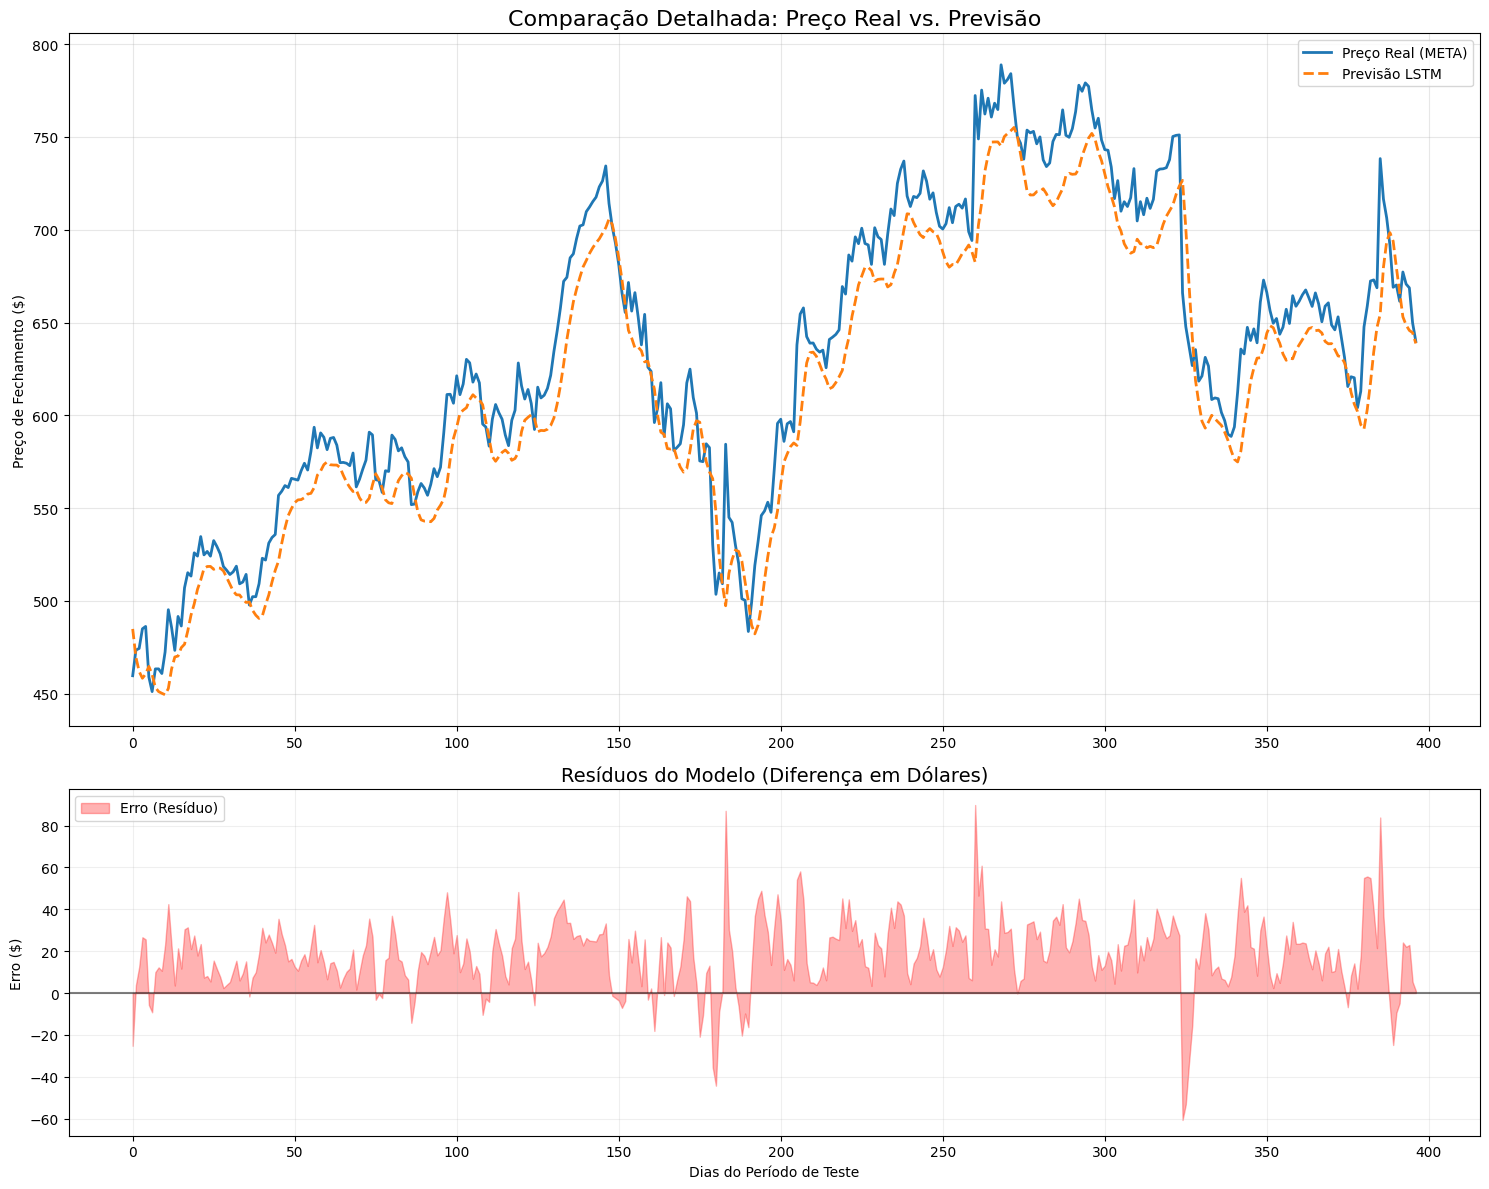

In [49]:
# --- Célula para Visualização de Resultados ---

erros = y_test_real - outputs_real

fig, ax = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 1]})

# Gráfico 1: Real vs Previsto (Zoom no período de teste)
ax[0].plot(y_test_real, label='Preço Real (META)', color='#1f77b4', linewidth=2)
ax[0].plot(outputs_real, label='Previsão LSTM', color='#ff7f0e', linestyle='--', linewidth=2)
ax[0].set_title('Comparação Detalhada: Preço Real vs. Previsão', fontsize=16)
ax[0].set_ylabel('Preço de Fechamento ($)')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Gráfico 2: Erro Residual (Diferença entre Real e Previsto)
ax[1].fill_between(range(len(erros)), erros.flatten(), color='red', alpha=0.3, label='Erro (Resíduo)')
ax[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax[1].set_title('Resíduos do Modelo (Diferença em Dólares)', fontsize=14)
ax[1].set_xlabel('Dias do Período de Teste')
ax[1].set_ylabel('Erro ($)')
ax[1].legend()
ax[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

/var/folders/qv/s9kbgw796kjbzj00pdkz7b7h0000gn/T/ipykernel_11906/391038974.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_anual = df['Close'].resample('Y').mean()
/var/folders/qv/s9kbgw796kjbzj00pdkz7b7h0000gn/T/ipykernel_11906/391038974.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df['Close'].resample('M').mean()


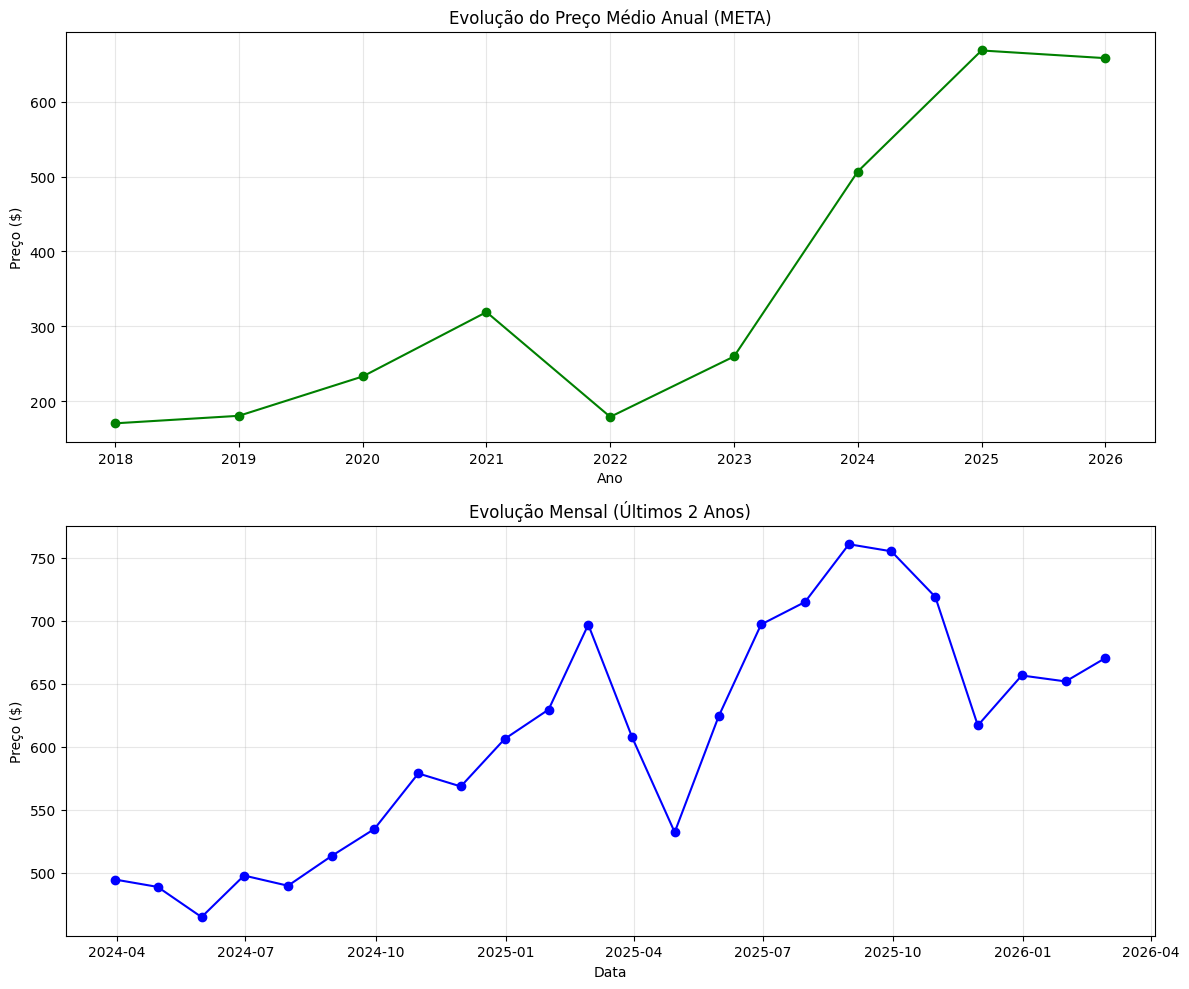

In [50]:
df_anual = df['Close'].resample('Y').mean()
df_mensal = df['Close'].resample('M').mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico Anual
ax1.plot(df_anual.index.year, df_anual.values, marker='o', linestyle='-', color='green')
ax1.set_title('Evolução do Preço Médio Anual (META)')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Preço ($)')
ax1.grid(True, alpha=0.3)

# Gráfico Mensal (pegando apenas os últimos 24 meses para não poluir)
dados_recentes = df_mensal.iloc[-24:] 
ax2.plot(dados_recentes.index, dados_recentes.values, marker='o', color='blue')
ax2.set_title('Evolução Mensal (Últimos 2 Anos)')
ax2.set_xlabel('Data')
ax2.set_ylabel('Preço ($)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
folder = 'environment' 

# Salva direto
torch.save(modelo.state_dict(), os.path.join(folder, 'modelo_lstm_meta.pth'))
joblib.dump(scaler, os.path.join(folder, 'scaler.pkl'))

print("Artefatos salvos com sucesso na pasta 'environment'.")

Artefatos salvos com sucesso na pasta 'environment'.
